In [1]:
# Imports
import json
import os

import numpy as np
import pandas as pd

In [2]:
# Constants
NSHARDS = 10
RESULTS_DIR = '/tmp/mwe'
LOCALDIR = '/tmp'

MODELS = ['GCN_AttributeMask', 'GCN_', 'GraphSAGE_', 'GraphSAGE_AttributeMask', 
          'GCN_CorruptedEmbeddingsReconstruction', 'GCN_CorruptedFeaturesReconstruction', 'GCN_AutoEncoding']
METRIC = 'test_rocauc_ovr'

In [3]:
dfs = []
for shard_idx in range(NSHARDS):
  filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
  print(filename)

  with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
    lines = f.readlines()
    records = map(json.loads, lines)
    dfs.append(pd.DataFrame.from_records(records))

# Construct df and remove nans
results_df = pd.concat(dfs)
results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
results_df.dropna(axis=0, inplace=True)
del dfs

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


In [4]:
results_df.columns

Index(['nvertex', 'avg_degree', 'feature_center_distance', 'feature_dim',
       'edge_center_distance', 'edge_feature_dim', 'p_to_q_ratio',
       'num_clusters', 'cluster_size_slope', 'power_exponent',
       ...
       'GCN__test_rocauc_ovo', 'GCN__test_logloss', 'GCN__train_epochs',
       'GCN__train_lr', 'GCN__train_lambda', 'GCN__model_in_channels',
       'GCN__model_hidden_channels', 'GCN__model_num_layers',
       'GCN__model_dropout', 'GCN__model_out_channels'],
      dtype='object', length=147)

In [5]:
type(results_df['GCN_CorruptedFeaturesReconstruction_model_partial_feature_reconstruction'][0])

numpy.bool_

In [6]:
# Function for 1D lineplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

def bucket_response_surface1d(results_df, xvar, metric='test_accuracy',
                              group=False, ngrid=25, custom_range=None):
  # BAD_VALS = [np.nan, np.inf, -np.inf]
  # results_df_inner = results_df[~results_df.isin(BAD_VALS).any(1)]
  results_df_inner = results_df.copy(deep=True)
  if custom_range is None:
    min_xvar = np.min(results_df_inner[xvar])
    max_xvar = np.max(results_df_inner[xvar])
  else:
    min_xvar = custom_range[0]
    max_xvar = custom_range[1]
  xrange = np.linspace(min_xvar, max_xvar, ngrid)
  def convert_value(z, range):
    return range[np.argmin(np.abs(range - z))]
  results_df_inner[xvar] = results_df_inner[xvar].apply(convert_value,
                                                        range=xrange)
  if group:
    return results_df_inner.groupby([xvar])[[xvar, metric]].mean()
  else:
    return results_df_inner

def plot_response_surface1d(param, metric, results_df,
                            models=MODELS,
                            reverse_x=False, ci=99):
  bucketed_dfs = []
  index_pos = 0
  grouped_index_pos = 0
  grouped_bucketed_dfs = []
  for model in models:
    model_metric = '%s_%s' % (model, metric)
    if model_metric not in results_df.columns:
      continue

    # Get and store ungrouped bucketed df
    bucketed_df = bucket_response_surface1d(results_df, param,
                                            metric=model_metric,
                                            group=False)
    bucketed_df = bucketed_df.rename(columns={model_metric: metric})
    bucketed_df['model'] = model
    new_index = list(range(index_pos, index_pos + bucketed_df.shape[0]))
    bucketed_df.index = new_index
    bucketed_dfs.append(bucketed_df)
    index_pos += bucketed_df.shape[0]

    # Get and store grouped bucketed df
    grouped_bucketed_df = bucket_response_surface1d(results_df, param,
                                                    metric=model_metric,
                                                    group=True)
    grouped_bucketed_df = grouped_bucketed_df.rename(
        columns={model_metric: metric})
    grouped_bucketed_df['model'] = model
    grouped_new_index = list(range(
        grouped_index_pos, grouped_index_pos + grouped_bucketed_df.shape[0]))
    grouped_bucketed_df.index = grouped_new_index
    grouped_bucketed_dfs.append(grouped_bucketed_df)
    grouped_index_pos += grouped_bucketed_df.shape[0]

    
    
  plot_df = pd.concat(bucketed_dfs, axis=0)

  # Make the plot
  fig = plt.figure(figsize=(10, 10))

  range_x = (np.min(results_df[param]), np.max(results_df[param]))
  if reverse_x:
    range_x = (range_x[1], range_x[0])

  sns.lineplot(data=plot_df, x=param, y=metric, hue="model", ci=ci)
  plt.title('%s vs %s' % (metric, param))
  plt.show()

In [7]:
results_df

,nvertex,avg_degree,feature_center_distance,feature_dim,edge_center_distance,edge_feature_dim,p_to_q_ratio,num_clusters,cluster_size_slope,power_exponent,...,GCN__test_rocauc_ovo,GCN__test_logloss,GCN__train_epochs,GCN__train_lr,GCN__train_lambda,GCN__model_in_channels,GCN__model_hidden_channels,GCN__model_num_layers,GCN__model_dropout,GCN__model_out_channels
0,267,11.520599,2.710736,16,2.0,2,35.24494,4,0.677186,3.0,...,1.0,0.86006,50,0.01,1000,16,16,4,0,4


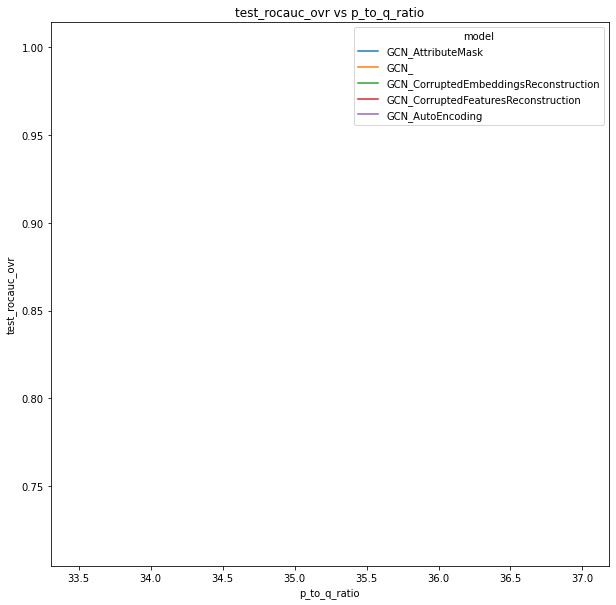

In [8]:
plot_response_surface1d('p_to_q_ratio', METRIC, results_df)